# Import

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem

import scipy
from sklearn import metrics
from ase.units import Hartree, mol, kcal, kJ

from IPython.core.display import display
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True  # Change output to SVG
IPythonConsole.drawOptions.addAtomIndices = True

In [2]:
# config
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({'font.size': 22})

# Change Matplotlib font to Helvetica
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.legend_handler import HandlerTuple

mpl.rcParams['font.family'] = 'Helvetica'
fm.findfont("Helvetica", fontext="ttx", rebuild_if_missing=False)

'/System/Library/Fonts/Helvetica.ttc'

In [3]:
import py3Dmol
def draw3d(
    mols,
    width=400,
    height=400,
    Hs=True,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
):
    try:
        p = py3Dmol.view(width=width, height=height)
        if type(mols) is not list:
            mols = [mols]
        for mol in mols:
            if multipleConfs:
                for conf in mol.GetConformers():
                    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                    p.addModel(mb, "sdf")
            else:
                if type(mol) is str:
                    if os.path.splitext(mol)[-1] == ".xyz":
                        xyz_f = open(mol)
                        line = xyz_f.read()
                        xyz_f.close()
                        p.addModel(line, "xyz")
                else:
                    mb = Chem.MolToMolBlock(mol, confId=confId)
                    p.addModel(mb, "sdf")
        p.setStyle({"sphere": {"radius": 0.4}, "stick": {}})
        if atomlabel:
            p.addPropertyLabels("index")  # ,{'elem':'H'}
        p.zoomTo()
        p.update()
        # p.show()
    except:
        print("py3Dmol, RDKit, and IPython are required for this feature.")

In [4]:
def get_atom_idx(mol, index=1):
  for i,a in enumerate(mol.GetAtoms()):
    if a.GetAtomMapNum() == index:
      return i

In [5]:
def roundUpToMultiple(number, multiple):
    num = number + (multiple - 1)
    return num - (num % multiple)

# Make regression plots for Figure 1

### Figure 1A

OBS! Using pkl_files = glob.glob(f'submitit_results/MCA_paper_fig5/*result.pkl')

In [135]:
pkl_files = glob.glob(f'submitit_results/MCA_paper_fig5/*result.pkl')

calc_failed = []
df = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    d = pd.read_pickle(f)
    if d[0] == 'error':
        calc_failed.append(f)
        continue
    df = df.append(d[-1], ignore_index=True, sort=False)

print(df.shape[0])
df.head(2)

99


,name,real_name,smiles,prod_smiles,MCA*,MCA*.1,S(N)Â¥N,s(N),N,solvent,M+,Other Condn,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values
0,mca8,O-Ethyl Dithiocarbonate,[S-]C(OCC)=S,S=C(SC)OCC,NaN,449.367985,13.317,0.69,19.3,MeCN,K+,NaN,"[[1, 5]]","[[double_bond, double_bond]]","[[CCOC(C)([S-])[S-], CCO[C-]([S-])SC]]","[[134.22937928140163, -inf]]","[[0, 1, 2, 5]]","[[anion_with_charge_minus1, double_bond, atom_...","[[CCOC(=S)SC, CCOC(C)([S+])[S-], CC[O+](C)C(=S...","[[483.8756449208595, -inf, -inf, 485.382226325..."
1,mca53,Triethylamine,CCN(CC)CC,CC[N+](CC)(C)CC,464.124376,NaN,8.996,0.52,17.3,DCM,NaN,NaN,[[]],[[]],[[]],[[]],[[2]],[[Amine]],[[CC[N+](C)(CC)CC]],[[510.51781089103315]]


In [136]:
def run_rxn(reactant, smarts, chrg=None):
    """ This functions is adapted to work for reaction SMARTS,
    where the atom with index 1 of the product is the attachment point """
    
    # Run reaction
    rxn = AllChem.ReactionFromSmarts(smarts)
    Chem.Kekulize(reactant,clearAromaticFlags=True)
    ps = rxn.RunReactants([reactant])
  
    # Find possible products
    product_mols = []
    product_smis = []
    product_sites = []
    if ps:
        ps = np.asarray(ps)[:,0] # Keep only first product of reaction
        #ps = np.concatenate(ps) # Concatenate all products
    else:
        return product_mols, product_smis, product_sites

    for mol in ps:
        # Canonicalize SMILES
        try:
            site = mol.GetAtomWithIdx(1).GetPropsAsDict()['react_atom_idx'] # OBS! the connecting atom is always the atom with index 1 in the product
            mol = Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mol)))
            smi = Chem.MolToSmiles(Chem.RemoveHs(mol))
            smi = Chem.CanonSmiles(smi)
            
            # mol3d = embed_organic_mol(Chem.AddHs(Chem.MolFromSmiles(smi)))
            # AllChem.UFFOptimizeMolecule(mol3d)
            # XYZBlock = Chem.MolToXYZBlock(mol3d)
            # molXYZ = Chem.MolFromXYZBlock(XYZBlock)
            # rdDetermineBonds.DetermineBonds(molXYZ, charge=chrg, covFactor=1.3, allowChargedFragments=True, useHueckel=False, embedChiral=False, useAtomMap=False)
            # smi = Chem.MolToSmiles(Chem.RemoveHs(molXYZ))
            
            # if not reactant.HasSubstructMatch(Chem.MolFromSmarts('O=[N+][O-]')) and not reactant.HasSubstructMatch(Chem.MolFromSmarts('[N-]=[N+]=[N-]')) and not reactant.HasSubstructMatch(Chem.MolFromSmarts('N#[N+][CH2-]')) and not reactant.HasSubstructMatch(Chem.MolFromSmarts('C1=CC=CO1')) and not reactant.HasSubstructMatch(Chem.MolFromSmarts('COC1=CC=CC=C1')) and not reactant.HasSubstructMatch(Chem.MolFromSmarts('[O-]C(OCC)=C[N+]1=CC=CC=C1')): # OBS!!! THIS IS A HACK DUE TO ISSUE #4884, [N-]=[N+]=[N-], N#[N+][CH2-], C1=CC=CO1, COC1=CC=CC=C1 and [O-]C(OCC)=C[N+]1=CC=CC=C1 are new issues
            #     _, resMols = getResonanceStructures(smi)
            #     smi = Chem.MolToSmiles(resMols[0])

            # smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
        except:
            continue
        
        # Keep only unique products that has the same number of atoms as the reactant as hydrogens are being removed and added
        if smi not in product_smis:
            product_mols.append(Chem.MolFromSmiles(smi))
            product_smis.append(smi)
            product_sites.append(site)
    
    return product_mols, product_smis, product_sites

In [137]:
MCA_paper_vals = []
MCA_vals = []
mayer_vals = []

for idx, row in df.iterrows():

    name = row['name']

    # if name in ['mca93', 'mca96']:
    #     continue

    reac_smis = row.smiles.split('.')
    reac_mols = [Chem.MolFromSmiles(smi) for smi in reac_smis]
    prod_smiles = row.prod_smiles.split('.')
    prod_mols = [Chem.MolFromSmiles(smi) for smi in prod_smiles]
    
    mayer_val = row['S(N)Â¥N']
    MCA_paper = row['MCA*']
    if str(MCA_paper) == 'nan':
        continue
        MCA_paper = row['MCA*.1']

    nuc_sites = row.nuc_sites[0]
    nuc_names = row.nuc_names[0]
    nuc_prod_smis = row.nuc_prod_smis[0]
    MCA_values = row.MCA_values[0]
    # MCA_values = row.xtb_MCA_values[0]

    if name == 'mca25':
        nuc_prod_smis[1] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca42':
        nuc_prod_smis[1] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca44':
        nuc_prod_smis[2] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca60':
        nuc_prod_smis[0] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca64':
        nuc_prod_smis[0] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca66':
        nuc_prod_smis[3] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca67':
        nuc_prod_smis[1] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca69':
        nuc_prod_smis[1] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca70':
        nuc_prod_smis[3] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca73':
        nuc_prod_smis[1] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca74':
        nuc_prod_smis[2] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca75':
        # nuc_prod_smis[8] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
        nuc_prod_smis[6] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca76':
        nuc_prod_smis[0] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca80':
        nuc_prod_smis[1] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca88':
        nuc_prod_smis[0] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca93':
        nuc_prod_smis[0] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))
    if name == 'mca99':
        nuc_prod_smis[3] = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles[0]))

    if name == 'mca96':
        prod_smiles = [nuc_prod_smis[0]]
        prod_mols = [Chem.MolFromSmiles(smi) for smi in prod_smiles]
    
    
    if len(prod_smiles) > 1:
        print(f'WARNING! {name} ({row.real_name}) has more than one product: {prod_smiles}')
        continue
    
    prod_match = None
    for i, nuc_prod_smi in enumerate(nuc_prod_smis):

        if Chem.MolFromSmiles(nuc_prod_smi).HasSubstructMatch(Chem.MolFromSmarts('[*-:1]-[*+;!$([N+](#[*])-[*-]):2]')):
            try:
                nuc_prod_smi = run_rxn(Chem.AddHs(Chem.MolFromSmiles(nuc_prod_smi)), '[*-:1]-[*+:2]>>[*+0:1]=[*+0:2]')[1][0]
            except:
                print('RUN RXN FAILED FOR:', name)

        if nuc_prod_smi == Chem.MolToSmiles(prod_mols[0]):
            prod_match = i
            nuc_site = nuc_sites[i]
            nuc_name = nuc_names[i]
            MCA_value = MCA_values[i]

            MCA_paper_vals.append(MCA_paper)
            MCA_vals.append(MCA_value)
            mayer_vals.append(mayer_val)
            # print('MATCH:', nuc_site, nuc_name, MCA_value, mayer_val, MCA_paper)
    

    if prod_match == None:
        print('WARNING!', name)
        display(Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in nuc_prod_smis]))
        display(Chem.Draw.MolsToGridImage(prod_mols))
    

In [138]:
y_true = MCA_vals #MCA_vals or MCA_paper_vals
y_pred = mayer_vals #mayer_vals
MSE_val = metrics.mean_squared_error(y_true, y_pred)
RMSE_val = metrics.mean_squared_error(y_true, y_pred, squared=False)
MAE_val = metrics.mean_absolute_error(y_true, y_pred)
R2_val = metrics.r2_score(y_true, y_pred)

print(f'Pred. MSE: {MSE_val:.4f}')
print(f'Pred. RMSE: {RMSE_val:.4f}')
print(f'Pred. MAE: {MAE_val:.4f}')
print(f'Pred. R2: {R2_val:.4f}')

Pred. MSE: 226728.7205
Pred. RMSE: 476.1604
Pred. MAE: 470.6221
Pred. R2: -36.5869


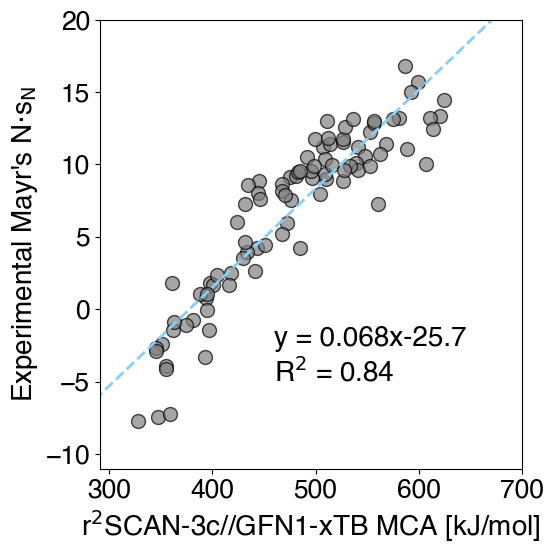

In [139]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('r$^2$SCAN-3c//GFN1-xTB MCA [kJ/mol]', fontsize=20)
plt.ylabel(r"Experimental Mayr's N$\cdot$s$_{\rm N}$", fontsize=20)

xmin = min(y_true) - (max(y_true) - min(y_true)) * 0.05
xmax = max(y_true) + (max(y_true) - min(y_true)) * 0.05
ymin = min(y_pred) - (max(y_pred) - min(y_pred)) * 0.05
ymax = max(y_pred) + (max(y_pred) - min(y_pred)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
plt.plot(np.arange(150,700,1), slope * np.arange(150,700,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)

fit_eq = str(np.poly1d(np.polyfit(y_true, y_pred, 1))).replace(' \n', '')
plt.text(xmax-180, ymin+4, f"y = {slope:.3f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20)

plt.xlim(291,700)
plt.ylim(-11,20)
plt.xticks(np.arange(300,701,100), fontsize=19)
plt.yticks(np.arange(-10,21,5), fontsize=19)

plt.tight_layout()
plt.savefig('MCA_exp_vs_calc.pdf')
plt.show()

### Figure 1C

OBS! Using pkl_files = glob.glob(f'submitit_results/MAA_paper_fig4/*result.pkl')

In [6]:
pkl_files = glob.glob(f'submitit_results/MAA_paper_fig4/*result.pkl')

calc_failed = []
df = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    d = pd.read_pickle(f)
    if d[0] == 'error':
        calc_failed.append(f)
        continue
    df = df.append(d[-1], ignore_index=True, sort=False)

print(df.shape[0])
df.head(2)

80


,name,real_name,smiles,MAA_minusdG_unconstrained_kjmol,MAA_minusdE_unconstrained_kjmol,MAA_minusdE_constrained_kjmol,MayrE,canon_smiles,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values
0,maa23,N-Methyl-N-methylenebenzenaminium,C=[N+](C)C1=CC=CC=C1,333.6,396.4,,-5.17,C=[N+](C)c1ccccc1,"[[0, 3, 4, 5, 6]]","[[Iminium, double_bond, double_bond, double_bo...","[[CCN(C)c1ccccc1, C=[N+](C)C1(C)C=CC=C[CH-]1, ...","[[410.23935366235673, -inf, 209.18074232479557...","[[3, 4, 5, 6, 0]]","[[double_bond, double_bond, double_bond, doubl...","[[C=[N+](C)C1(C)C=CC=C[CH+]1, C=[N+](C)[C+]1C=...","[[226.82128967274912, 258.3977090700064, 259.0..."
1,maa74,Cyclopentanone,O=C1CCCC1,88.9,150.1,,-21.00,O=C1CCCC1,"[[1, 0]]","[[Ketone, double_bond]]","[[CC1([O-])CCCC1, CO[C-]1CCCC1]]","[[122.3093912829645, -70.90698729839642]]","[[0, 1]]","[[Ketone, double_bond]]","[[CO[C+]1CCCC1, CC1([O+])CCCC1]]","[[343.41476942109875, -inf]]"


In [7]:
MAA_paper_vals = []
MAA_vals = []
mayer_vals = []
counter = 0
for idx, row in df.iterrows():

    name = str(row['name'])

    if name in ['maa57', 'maa58', 'maa71', 'maa74', 'maa75', 'maa76']:
        continue

    reac_smis = row.smiles.split('.')
    reac_mols = [Chem.MolFromSmiles(smi) for smi in reac_smis]

    # mayer_val = row['score']
    mayer_val = row['MayrE']
    MAA_paper = row['MAA_minusdG_unconstrained_kjmol']

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    elec_prod_smis = row.elec_prod_smis[0]
    MAA_values = row.MAA_values[0]

    index = np.argmax(MAA_values)
    elec_site = elec_sites[index]
    elec_name = elec_names[index]
    MAA_value = MAA_values[index]
    
    if '-inf' in [str(x) for x in MAA_values]:
        counter += 1

    if str(MAA_value) == '-inf':
        print(name)
        continue

    # MAA_paper_vals.append(MAA_paper)
    MAA_vals.append(MAA_value)
    mayer_vals.append(mayer_val)
    # print('MATCH:', elec_site, elec_name, MAA_value, mayer_val, MAA_paper)
    # break

In [8]:
len(mayer_vals)

74

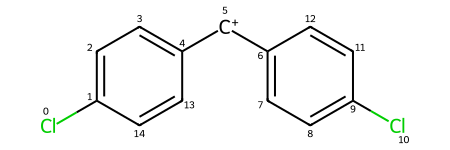

[5, 1, 2, 3, 4]
[489.9816999626346, 405.4018258312717, 170.35258415853605, 372.0090584056452, -inf]


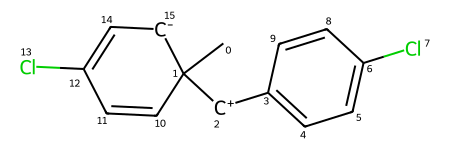

In [9]:
for idx, row in df[df['name'] == 'maa3'].iterrows():
    display(Chem.MolFromSmiles(row.smiles))
    print(row.elec_sites[0])
    print(row.MAA_values[0])
    display(Chem.MolFromSmiles(row.elec_prod_smis[0][row.elec_sites[0].index(4)]))

In [10]:
counter, len(mayer_vals)

(54, 74)

In [11]:
y_true = MAA_vals #MAA_vals or MAA_paper_vals
y_pred = mayer_vals #mayer_vals
MSE_val = metrics.mean_squared_error(y_true, y_pred)
RMSE_val = metrics.mean_squared_error(y_true, y_pred, squared=False)
MAE_val = metrics.mean_absolute_error(y_true, y_pred)
R2_val = metrics.r2_score(y_true, y_pred)

print(f'Pred. MSE: {MSE_val:.4f}')
print(f'Pred. RMSE: {RMSE_val:.4f}')
print(f'Pred. MAE: {MAE_val:.4f}')
print(f'Pred. R2: {R2_val:.4f}')

Pred. MSE: 121112.6749
Pred. RMSE: 348.0125
Pred. MAE: 339.3902
Pred. R2: -15.4762


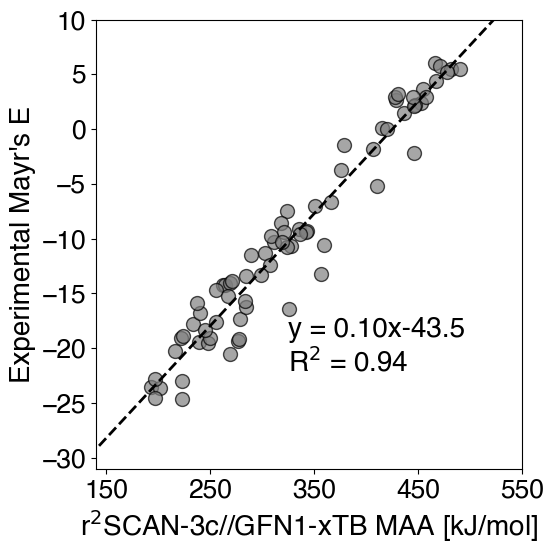

In [13]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('r$^2$SCAN-3c//GFN1-xTB MAA [kJ/mol]', fontsize=20)
plt.ylabel("Experimental Mayr's E", fontsize=20)

xmin = min(y_true) - (max(y_true) - min(y_true)) * 0.05
xmax = max(y_true) + (max(y_true) - min(y_true)) * 0.05
ymin = min(y_pred) - (max(y_pred) - min(y_pred)) * 0.05
ymax = max(y_pred) + (max(y_pred) - min(y_pred)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
plt.plot(np.arange(-10,600,1), slope * np.arange(-10,600,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)

fit_eq = str(np.poly1d(np.polyfit(y_true, y_pred, 1))).replace(' \n', '')
plt.text(xmax-180, ymin+4, f"y = {slope:.2f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20)

plt.xlim(140,550)
plt.ylim(-31,10)
plt.xticks(np.arange(150,551,100), fontsize=19)
plt.yticks(np.arange(-30,11,5), fontsize=19)

plt.tight_layout()
plt.savefig('MAA_exp_vs_calc.pdf')
plt.show()

### Figure 1B

OBS! Using pkl_files = glob.glob(f'submitit_results/nucleophilicity_with_names/*result.pkl')

In [122]:
pkl_files = glob.glob(f'submitit_results/nucleophilicity_with_names/*result.pkl')

calc_failed = []
df = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    d = pd.read_pickle(f)
    if d[0] == 'error':
        calc_failed.append(f)
        continue
    df = df.append(d[-1], ignore_index=True, sort=False)

print(df.shape[0])
df.head(2)

1232


,smiles,score,name,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values
0,CCC[O:1]CC,-3.099782,baldiNUC145,[[]],[[]],[[]],[[]],[[3]],[[Ether]],[[CCC[O+](C)CC]],[[354.08882639266085]]
1,CC(C)[O:1]Cc1ccccc1,-2.486420,baldiNUC979,"[[5, 6, 7, 8]]","[[double_bond, double_bond, double_bond, doubl...","[[CC(C)[O:1]CC1(C)C=CC=C[CH-]1, CC1C=CC=C[C-]1...","[[65.4099417955149, 69.6796430812683, 61.90951...","[[3, 5, 6, 7, 8]]","[[Ether, double_bond, double_bond, double_bond...","[[CC(C)[O+](C)Cc1ccccc1, CC(C)[O:1]CC1(C)C=CC=...","[[344.4367773756385, 309.44346233503893, 314.5..."


In [123]:
df_nuc = copy.deepcopy(df)

In [124]:
# Add indices of mapped atoms sorted according to the mapping
df['sorted_indices'] = df.apply(lambda row: get_atom_idx(Chem.MolFromSmiles(row.smiles)), axis=1)
df.head(1)

,smiles,score,name,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values,sorted_indices
0,CCC[O:1]CC,-3.099782,baldiNUC145,[[]],[[]],[[]],[[]],[[3]],[[Ether]],[[CCC[O+](C)CC]],[[354.08882639266085]],3


In [125]:
MCA_paper_vals = []
MCA_vals = []
for idx, row in df.iterrows():
    
    name = str(row['name'])

    if name in ['baldiNUC694', 'baldiNUC1195']:
        continue

    nuc_sites = row.nuc_sites[0]
    nuc_names = row.nuc_names[0]
    MCA_values = row.MCA_values[0]
    
    index = nuc_sites.index(row.sorted_indices)
    MCA_value = MCA_values[index]

    if str(MCA_value) == '-inf':
        print(name)
        continue
    
    MCA_vals.append(MCA_value)

    MCA_paper = row['score']
    MCA_paper_vals.append(MCA_paper)

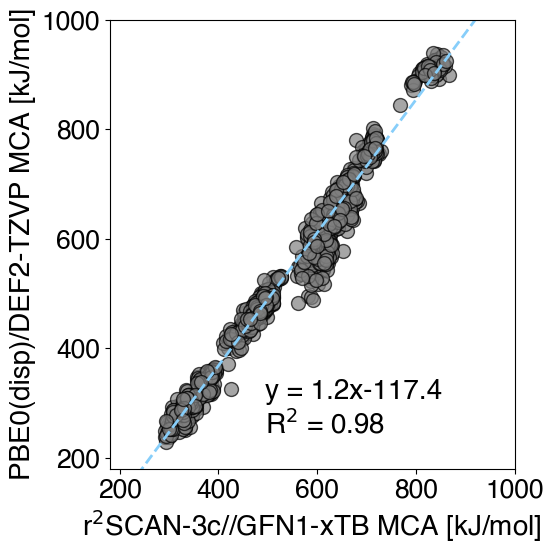

In [127]:
y_true = MCA_vals
y_pred = (np.array(MCA_paper_vals) + 24.8) / 0.072

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('r$^2$SCAN-3c//GFN1-xTB MCA [kJ/mol]', fontsize=20)
plt.ylabel('PBE0(disp)/DEF2-TZVP MCA [kJ/mol]', fontsize=20)

xmin = min(y_true) - (max(y_true) - min(y_true)) * 0.05
xmax = max(y_true) + (max(y_true) - min(y_true)) * 0.05
ymin = min(y_pred) - (max(y_pred) - min(y_pred)) * 0.05
ymax = max(y_pred) + (max(y_pred) - min(y_pred)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
plt.plot(np.arange(200,1000,1), slope * np.arange(200,1000,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)

fit_eq = str(np.poly1d(np.polyfit(y_true, y_pred, 1))).replace(' \n', '')
plt.text(xmax-400, ymin+50, f"y = {slope:.1f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20)


plt.xlim(180,1000) 
plt.ylim(180,1000) 
plt.xticks(np.arange(200,1001,200), fontsize=19) 
plt.yticks(np.arange(200,1001,200), fontsize=19) 

plt.tight_layout()
plt.savefig('MCA_mlpapervals_vs_calc.pdf')
plt.show()

### Figure 1D

OBS! Using pkl_files = glob.glob(f'submitit_results/electrophilicity_with_names/*result.pkl')

In [140]:
pkl_files = glob.glob(f'submitit_results/electrophilicity_with_names/*result.pkl')

calc_failed = []
df = pd.read_pickle(pkl_files[0])[-1]
for f in pkl_files[1:]:
    d = pd.read_pickle(f)
    if d[0] == 'error':
        calc_failed.append(f)
        continue
    df = df.append(d[-1], ignore_index=True, sort=False)

print(df.shape[0])
df.head(2)

1113


,smiles,score,name,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values
0,CCCC=C[CH+:1]CC,5.521134,baldiELEC694,"[[5, 3, 4]]","[[Carbocation, double_bond, double_bond]]","[[CCCC=CC(C)CC, CCCC(C)[CH-][CH+:1]CC, CCC[CH-...","[[475.652120075305, 474.6316376753384, -inf]]","[[3, 4]]","[[double_bond, double_bond]]","[[CCCC(C)[CH+][CH+:1]CC, CCC[CH+]C(C)[CH+:1]CC]]","[[-inf, 203.06718128419016]]"
1,CC(C)[C:1](=O)NC,-36.866750,baldiELEC369,"[[3, 4]]","[[Amide, double_bond]]","[[CNC(C)([O-])C(C)C, CN[C-](OC)C(C)C]]","[[68.10710071318317, -141.63779226806946]]","[[4, 3, 5]]","[[Amide, double_bond, atom_with_lone_pair]]","[[C[NH+]=C(OC)C(C)C, CNC(C)([O+])C(C)C, CC(C)[...","[[378.7680110511137, -inf, 389.030616908567]]"


In [141]:
df_elec = copy.deepcopy(df)

In [142]:
# Add indices of mapped atoms sorted according to the mapping
df['sorted_indices'] = df.apply(lambda row: get_atom_idx(Chem.MolFromSmiles(row.smiles)), axis=1)
df.head(1)

,smiles,score,name,elec_sites,elec_names,elec_prod_smis,MAA_values,nuc_sites,nuc_names,nuc_prod_smis,MCA_values,sorted_indices
0,CCCC=C[CH+:1]CC,5.521134,baldiELEC694,"[[5, 3, 4]]","[[Carbocation, double_bond, double_bond]]","[[CCCC=CC(C)CC, CCCC(C)[CH-][CH+:1]CC, CCC[CH-...","[[475.652120075305, 474.6316376753384, -inf]]","[[3, 4]]","[[double_bond, double_bond]]","[[CCCC(C)[CH+][CH+:1]CC, CCC[CH+]C(C)[CH+:1]CC]]","[[-inf, 203.06718128419016]]",5


In [143]:
MAA_paper_vals = []
MAA_vals = []
for idx, row in df.iterrows():
    
    name = str(row['name'])

    # if name in ['baldiELEC275']:
    #     continue

    elec_sites = row.elec_sites[0]
    elec_names = row.elec_names[0]
    MAA_values = row.MAA_values[0]
    
    index = elec_sites.index(row.sorted_indices)
    MAA_value = MAA_values[index]

    if str(MAA_value) == '-inf':
        print(name)
        continue
    
    MAA_vals.append(MAA_value)

    MAA_paper = row['score']
    MAA_paper_vals.append(MAA_paper)

baldiELEC275


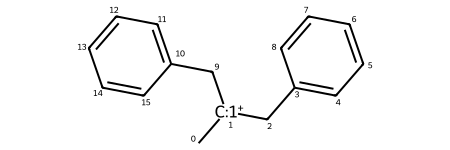

In [144]:
Chem.MolFromSmiles(df[df['name'] == 'baldiELEC275'].smiles.tolist()[0])

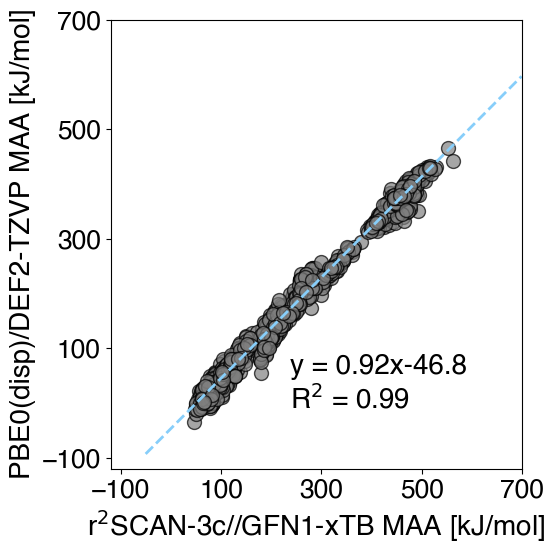

In [145]:
y_true = MAA_vals
y_pred = (np.array(MAA_paper_vals) + 37.9) / 0.11

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, marker='o', s=100, alpha=0.7, color='gray', edgecolors='k')
plt.xlabel('r$^2$SCAN-3c//GFN1-xTB MAA [kJ/mol]', fontsize=20)
plt.ylabel('PBE0(disp)/DEF2-TZVP MAA [kJ/mol]', fontsize=20)

xmin = min(y_true) - (max(y_true) - min(y_true)) * 0.05
xmax = max(y_true) + (max(y_true) - min(y_true)) * 0.05
ymin = min(y_pred) - (max(y_pred) - min(y_pred)) * 0.05
ymax = max(y_pred) + (max(y_pred) - min(y_pred)) * 0.05

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
plt.plot(np.arange(-50,700,1), slope * np.arange(-50,700,1) + intercept, 'LightSkyBlue', linestyle='dashed', lw=2)

fit_eq = str(np.poly1d(np.polyfit(y_true, y_pred, 1))).replace(' \n', '')
plt.text(xmax-350, ymin+50, f"y = {slope:.2f}x{intercept:.1f} \nR$^2$ = {r_value**2:.2f}", color='k', fontsize=20)

plt.xlim(-120,700) 
plt.ylim(-120,700) 
plt.xticks(np.arange(-100,701,200), fontsize=19) 
plt.yticks(np.arange(-100,701,200), fontsize=19) 

plt.tight_layout()
plt.savefig('MAA_mlpapervals_vs_calc.pdf')
plt.show()

# TIMINGS FOR DATA IN FIGURE 1B and 1D

In [146]:
print('Amount of data:', len(list(np.array([len(x[0]) for x in df_elec.elec_sites.tolist()]) + np.array([len(x[0]) for x in df_elec.nuc_sites.tolist()])) + list(np.array([len(x[0]) for x in df_nuc.elec_sites.tolist()]) + np.array([len(x[0]) for x in df_nuc.nuc_sites.tolist()]))))

Amount of data: 2345


In [147]:
print('Average number of heavy atoms in data:', np.mean([Chem.MolFromSmiles(smi).GetNumHeavyAtoms() for smi in df_elec.smiles.tolist()] + [Chem.MolFromSmiles(smi).GetNumHeavyAtoms() for smi in df_nuc.smiles.tolist()]))

Average number of heavy atoms in data: 9.74498933901919


In [148]:
print('Average number of identified sites in data:', np.mean(list(np.array([len(x[0]) for x in df_elec.elec_sites.tolist()]) + np.array([len(x[0]) for x in df_elec.nuc_sites.tolist()])) + list(np.array([len(x[0]) for x in df_nuc.elec_sites.tolist()]) + np.array([len(x[0]) for x in df_nuc.nuc_sites.tolist()]))))

Average number of identified sites in data: 6.199147121535181


In [149]:
### TIMINGS FOR DATA IN FIGURE 1B and 1D ###
print(f"MEDIAN timing:  \t {np.median(list(np.loadtxt('submitit_results/nucleophilicity_with_names/timings.txt')) + list(np.loadtxt('submitit_results/electrophilicity_with_names/timings.txt'))) / 60:.2f} minutes")
print(f"AVERAGE timing: \t {np.mean(list(np.loadtxt('submitit_results/nucleophilicity_with_names/timings.txt')) + list(np.loadtxt('submitit_results/electrophilicity_with_names/timings.txt'))) / 60:.2f} minutes")

MEDIAN timing:  	 1.97 minutes
AVERAGE timing: 	 2.79 minutes
